<a href="https://colab.research.google.com/github/Ki-i/APRiL/blob/master/0502_cnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
workspace_dir = '.'
#!unzip -q "/content/drive/My Drive/crypko_data.zip" -d "{workspace_dir}/"

In [13]:
from torch.nn import Module
from torch import nn
import numpy as np
import math
import torch
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import sys
import scipy.io as scio
import pylab
import torch.nn.functional as F

In [14]:
class DnCNN(nn.Module):
    def __init__(self):
        super(DnCNN, self).__init__()
        channels=3
        num_of_layers=10
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
 
        self.dncnn = nn.Sequential(*layers)
        self.fc1=nn.Linear( 3*50*100,6)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(6,2)
        self.dropout = nn.Dropout(p=0.3)  # dropout训练
    def forward(self, x):
        y = self.dncnn(x)
        #print(y.size())
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.dropout(y)
        y = self.relu(y)
        y = self.fc2(y)
        #print(y.size())
        return y

In [ ]:
class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 64, 5)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*2*9, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 6)
        self.dropout = nn.Dropout(p=0.3)  # dropout训练

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = self.conv3(y)
        y = self.relu3(y)
        y = self.pool3(y)
        #print(y.size())
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.dropout(y)
        y = self.relu3(y)
        y = self.fc2(y)
        # y = self.relu4(y)
        # y = self.fc3(y)
        # y = self.relu5(y)
        return y

In [15]:
def get_data(dataset_path, fm, dev_ratio):
    print("load data from path1:", dataset_path)
    data = scio.loadmat(os.path.join(dataset_path, fm))

    del data['__header__']
    del data['__globals__']
    del data['__version__']
    # print(x_data.keys())
    # print(y_data.keys())
    # print(int(len(x_data)/3))
    #datalen = int(len(x_data) / 3)
    datalen=5000
    x = np.zeros((datalen, 3, 50, 100), dtype=np.float)
    y = np.zeros(datalen, dtype=np.uint8)
    for i in range(1, datalen):
        xkey = 'x' + str(i)
        #print(xkey)
        x[i] = data[xkey]
        
        ykey = 'y' + str(i)
        if(i<=datalen/2):
          y[i] = 1#噪声
        else:
          y[i] = 0
        #if i==1:
        #  print(x[1])
        #  print(y_data[ykey])
        #  print(y[1])
        

    data_size = len(y)
    train_size = int(data_size * (1 - dev_ratio))
    state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(state)
    np.random.shuffle(y)
    # print("train size:", train_size)
    # print("dev size:", data_size - train_size)
    x_train = x[:train_size]
    y_train = y[:train_size]
    x_dev = x[train_size:]
    y_dev = y[train_size:]
    return x_train, y_train, x_dev, y_dev

In [16]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.data_size = len(self.y)
        #norm_mean = [0.485, 0.456, 0.406]
        #norm_std = [0.229, 0.224, 0.225]
        self.img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            # transforms.Normalize(norm_mean, norm_std),
        ])

    def __len__(self):
        return self.data_size

    def __getitem__(self, item):
        '''
        这个函数是关键，通过item(索引)来取数据集中的数据，
        一般来说在这里才将图像数据加载入内存，之前存的是图像的保存路径
        '''
        ycut=self.y[item]
        #ycut=ycut[101:-6:400,1:-5:500]

        label = torch.tensor(ycut,dtype=torch.long)
       
        #label = torch.reshape(label, (1, -1))
        xcut = self.x[item]
        #xcut = xcut[101:-6:400,1:-5:500]
        x = torch.from_numpy(xcut)
        #x=x.unsqueeze(0)
        #label=label.squeeze(0)
        x=x.float()
       
        x = torch.div(x, 255.)
      
        #print(x.size())
        #print(label)
        #label=torch.div(label, 255.)
        return x, label

In [ ]:
x=np.array([1,2,3,4])
x=x/4
print(x)

[0.25 0.5  0.75 1.  ]


In [6]:
def psnr(target_data, ref_data):
    # target:目标图像  ref:参考图像  scale:尺寸大小
    # assume RGB image
    #target_data = np.array(target)
    #target_data = target_data[scale:-scale, scale:-scale]

    #ref_data = np.array(ref)
    #ref_data = ref_data[scale:-scale, scale:-scale]
    im = ref_data.max()
    print('参考图像峰值', ref_data.max(), ref_data.min())
    print('实际图像峰值', target_data.max(), target_data.min())
    target_data = target_data * (ref_data.max() / target_data.max())
    #print('实际图像峰值', target_data.max(), target_data.min())
    diff = ref_data - target_data
    diff = diff.flatten('C')

    #rmse = math.sqrt(np.mean(diff ** 2.))
    #return 20 * math.log10(math.pow(im,2) / rmse)
    mse = np.mean(diff ** 2.)
    return 20 * math.log10(math.pow(im,2) / mse)

def ab_err(target_data, ref_data):
  diff = abs(ref_data - target_data)/ref_data
  diff=diff.cpu().data.numpy()
  tdiff=diff[0:,0:2]
  vdiff=diff[0:,3:5]
  
  
  terr = np.mean(tdiff)
  verr = np.mean(vdiff)

  return terr,verr

load data from path1: /content/drive/My Drive/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


epoch 0.0000 train acc: 0.4970,train loss: 0.6978, dev acc: 0.5098, dev loss: 0.6934
epoch 1.0000 train acc: 0.5379,train loss: 0.6869, dev acc: 0.6199, dev loss: 0.6763
epoch 2.0000 train acc: 0.5973,train loss: 0.6742, dev acc: 0.6705, dev loss: 0.6654
epoch 3.0000 train acc: 0.6316,train loss: 0.6633, dev acc: 0.6897, dev loss: 0.6533
epoch 4.0000 train acc: 0.6606,train loss: 0.6522, dev acc: 0.7435, dev loss: 0.6401
epoch 5.0000 train acc: 0.6830,train loss: 0.6359, dev acc: 0.7808, dev loss: 0.6249
epoch 6.0000 train acc: 0.7266,train loss: 0.6211, dev acc: 0.8082, dev loss: 0.6086
epoch 7.0000 train acc: 0.7581,train loss: 0.6033, dev acc: 0.8091, dev loss: 0.5906
epoch 8.0000 train acc: 0.7766,train loss: 0.5827, dev acc: 0.8508, dev loss: 0.5703
epoch 9.0000 train acc: 0.8005,train loss: 0.5617, dev acc: 0.8992, dev loss: 0.5474
epoch 10.0000 train acc: 0.8184,train loss: 0.5429, dev acc: 0.9284, dev loss: 0.5251
epoch 11.0000 train acc: 0.8405,train loss: 0.5173, dev acc: 0.9

NameError: ignored

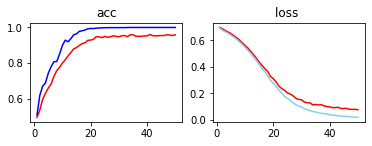

In [10]:

if __name__ == '__main__':

    batch_size = 32
    lr=1e-3
    #lr=1e-4#loss:11.72 10.74
    #lr=1e-3#9.6519
    #lr=0.01#8.3690
    #lr=0.1#8.2 7.72 7.71 ..7156.7147
    log_dir='/content/drive/My Drive/ClassificationModel0425.pth'
    #数据集加载
    dataset_path = '/content/drive/My Drive/'
    x_train, y_train, x_dev, y_dev = get_data(dataset_path, 'TrainDataClassification.mat', 0.4)
    #print(x_train[0])
    train_dataset = MyDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    dev_dataset = MyDataset(x_dev, y_dev)
    dev_loader = DataLoader(train_dataset, batch_size=batch_size)

    model = DnCNN()
    #model = Model()
    #模型加载
    start_epoch=0
    '''
    if os.path.exists(log_dir):
        checkpoint = torch.load(log_dir)
        model.load_state_dict(checkpoint['net'])
        start_epoch = checkpoint['epoch']
        print('加载 epoch {} 成功！'.format(start_epoch))
    else:
        start_epoch = 0
        print('无保存模型，将从头开始训练！')
    '''
    sgd = SGD(model.parameters(), lr)

    cost = CrossEntropyLoss()
    criterion = MSELoss(reduction='sum')
    epoch = 50
    use_GPU = True
    if use_GPU:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model.to(device)
    epoch_train_loss_list = []
    epoch_dev_loss_list = []
    epoch_train_acc_list = []
    epoch_dev_acc_list = []

    for _epoch in range(epoch):
        model.train()
        epoch_train_loss = 0
        epoch_dev_loss = 0
        epoch_train_acc = 0
        epoch_dev_acc = 0
        train_num=0
        dev_num = 0
        for idx, (train_x, train_label) in enumerate(train_loader):
            s = train_label.shape[0]
            sgd.zero_grad()
            predict_y = model(train_x.to(device))
            #print(train_label.size())
            #print(predict_y.size())
            #loss = cost(predict_y, train_label.to(device))
            loss = F.cross_entropy(predict_y, train_label.to(device))
            epoch_train_loss += loss.item()
            label_pred = np.argmax(predict_y.cpu().data.numpy(), axis=1)
            acc = np.sum(label_pred == train_label.numpy())
            # print("batch Train acc:",acc / s)
            epoch_train_acc += acc / s
            train_num+=1
            loss.backward()
            sgd.step()

        correct = 0
        _sum = 0
        model.eval()

        with torch.no_grad():
            for idx, (dev_x, dev_label) in enumerate(dev_loader):
                s = dev_label.shape[0]
                predict_y = model(dev_x.to(device))
                # print(predict_y[0], dev_label[0])
                loss = cost(predict_y, dev_label.to(device))
                epoch_dev_loss += loss.item()
                label_pred = np.argmax(predict_y.cpu().data.numpy(), axis=1)
                acc = np.sum(label_pred == dev_label.numpy())
                batch_acc=acc / s
                dev_num+=1
                # print("batch_acc::",batch_acc)
                epoch_dev_acc += acc / s
                # print("devacc", acc);
        epoch_train_loss_list.append(epoch_train_loss / train_num)
        epoch_dev_loss_list.append(epoch_dev_loss / train_num)
        epoch_train_acc_list.append(epoch_train_acc / dev_num)
        epoch_dev_acc_list.append(epoch_dev_acc / dev_num)
        print("epoch {:.4f} train acc: {:.4f},train loss: {:.4f}, dev acc: {:.4f}, dev loss: {:.4f}".format(_epoch,epoch_train_acc / train_num, epoch_train_loss / train_num,epoch_dev_acc / dev_num, epoch_dev_loss / dev_num))
   
    
    state = {'net':model.state_dict(),  'epoch':epoch}
    torch.save(state, log_dir)
    t = np.arange(1, len(epoch_train_loss_list) + 1)
    acc_plot = plt.subplot(2, 2, 1)
    plt.title('acc')
    plt.plot(t, epoch_train_acc_list, color='red', label='train acc')
    plt.plot(t, epoch_dev_acc_list, color='blue', label='dev acc')
    loss_plot = plt.subplot(2, 2, 2)
    plt.title('loss ')
    plt.plot(t, epoch_train_loss_list, color='red', label='train loss')
    plt.plot(t, epoch_dev_loss_list, color='skyblue', label='dev loss')
    plt.savefig(imgname)

In [ ]:
    acc_plot = plt.subplot(2, 2, 1)
    plt.title('acc')
    plt.plot(t, epoch_train_acc_list, color='red', label='train acc')
    plt.plot(t, epoch_dev_acc_list, color='blue', label='dev acc')
    loss_plot = plt.subplot(2, 2, 2)
    plt.title('loss ')
    plt.plot(t, epoch_train_loss_list, color='red', label='train loss')
    plt.plot(t, epoch_dev_loss_list, color='skyblue', label='dev loss')
    plt.savefig(imgname)

In [39]:
def get_test_data(dataset_path, fm, SNR):
    print("load data from path1:", dataset_path)
    data = scio.loadmat(os.path.join(dataset_path, fm))

    del data['__header__']
    del data['__globals__']
    del data['__version__']
    # print(x_data.keys())
    # print(y_data.keys())
    # print(int(len(x_data)/3))
    #datalen = int(len(x_data) / 3)
    datalen=500
    x_test = np.zeros((datalen, 3, 50, 100), dtype=np.float)
    y_test = np.zeros(datalen, dtype=np.uint8)
    for i in range(1,int(datalen/2)):
        xkey1 = 'x' + str((SNR+5)*250+i)
        xkey2 = 'x' + str((SNR+5)*250+2500+i)
        #print(xkey)
        x_test[i] = data[xkey1]
        x_test[i+int(datalen/2)] = data[xkey2]
        
        y_test[i] = 1
        y_test[i+int(datalen/2)] = 0
        #if i==1:
        #  print(x[1])
        #  print(y_data[ykey])
        #  print(y[1])
        

    
    return x_test, y_test
class MyTestDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.data_size = len(self.y)
        #norm_mean = [0.485, 0.456, 0.406]
        #norm_std = [0.229, 0.224, 0.225]
        self.img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            # transforms.Normalize(norm_mean, norm_std),
        ])

    def __len__(self):
        return self.data_size

    def __getitem__(self, item):
        '''
        这个函数是关键，通过item(索引)来取数据集中的数据，
        一般来说在这里才将图像数据加载入内存，之前存的是图像的保存路径
        '''
        ycut=self.y[item]
        #ycut=ycut[101:-6:400,1:-5:500]

        label = torch.tensor(ycut,dtype=torch.long)
        #label = torch.reshape(label, (1, -1))
        xcut = self.x[item]
        #xcut = xcut[101:-6:400,1:-5:500]
        x = torch.from_numpy(xcut)
        #x=x.unsqueeze(0)
        #label=label.squeeze(0)
        x=x.float()
        #label=label.float()
        x = torch.div(x, 255.)
        #print(label)
        #label = torch.div(label, 10000.)
        #print(x)
        #print(label)
        #label=torch.div(label, 255.)
        return x, label

True
加载 epoch 50 成功！
load data from path1: /content/drive/My Drive/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


ValueError: ignored

True
加载 epoch 50 成功！
load data from path1: /content/drive/My Drive/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


0.6666666666666666
0.5416666666666666
0.7083333333333334
0.5833333333333334
0.4583333333333333
0.5833333333333334
0.5833333333333334
0.4583333333333333
0.5416666666666666
0.4583333333333333
0.3333333333333333
0.5416666666666666
0.7916666666666666
0.4166666666666667
0.625
0.375
0.5
0.5416666666666666
0.5416666666666666
0.6666666666666666
0.0
0.5198412698412698
load data from path1: /content/drive/My Drive/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0.5833333333333334
0.6666666666666666
0.5833333333333334
0.5833333333333334
0.5
0.5833333333333334
0.5
0.4583333333333333
0.625
0.5
0.5833333333333334
0.5
0.3333333333333333
0.5833333333333334
0.625
0.4583333333333333
0.5
0.4166666666666667
0.375
0.375
0.0
0.492063492063492
load data from path1: /content/drive/My Drive/
0.5
0.4583333333333333
0.5833333333333334
0.4166666666666667
0.4583333333333333
0.6666666666666666
0.5833333333333334
0.4583333333333333
0.5833333333333334
0.5416666666666666
0.4583333333333333
0.375
0.375
0.5833333333333334
0.4583333333333333
0.5416666666666666
0.4166666666666667
0.4583333333333333
0.375
0.5
0.0
0.4662698412698412
load data from path1: /content/drive/My Drive/
0.4583333333333333
0.3333333333333333
0.6666666666666666
0.5833333333333334
0.5416666666666666
0.4583333333333333
0.375
0.625
0.5
0.4583333333333333
0.5
0.4166666666666667
0.5
0.20833333333333334
0.6666666666666666
0.3333333333333333
0.375
0.4583333333333333
0.3333333333333333
0.4166666666666667


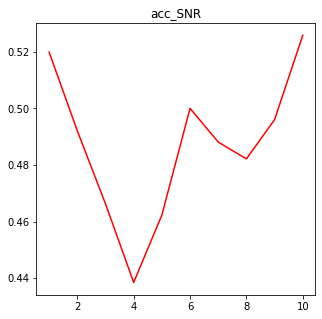

In [46]:
batch_size = 24
use_GPU = True
if use_GPU:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = DnCNN()
model.to(device)
print(torch.cuda.is_available())
log_dir = '/content/drive/My Drive/ClassificationModel0425.pth'
if os.path.exists(log_dir):
    checkpoint = torch.load(log_dir)
    model.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
    print('加载 epoch {} 成功！'.format(start_epoch))
else:
    start_epoch = 0
    print('加载失败')
dataset_path="/content/drive/My Drive/"
SNR_acc_list = []
for SNR in range(-5, 5):
    x_test, y_test = get_test_data(dataset_path, 'TrainDataClassification.mat', SNR)
    test_dataset = MyTestDataset(x_test, y_test)
    train_loader = DataLoader(test_dataset, batch_size=batch_size)


    test_num = 0
    test_derror=0
    test_verror=0
    test_acc = 0
    for idx, (test_x, test_label) in enumerate(train_loader):
        epoch_dev_acc = 0
        train_num = 0
        dev_num = 0
        epoch_dev_derror = 0
        epoch_dev_verror = 0
        epoch_train_derror = 0
        epoch_train_verror = 0
        s = test_label.shape[0]
        predict_y = model(test_x.to(device))
        
        loss = F.cross_entropy(predict_y, test_label.to(device))
            
        epoch_dev_loss += loss.item()
        label_pred = np.argmax(predict_y.cpu().data.numpy(), axis=1)
        acc = np.sum(label_pred == dev_label.numpy())
        batch_acc=acc / s
        print(batch_acc)

        # print("batch_acc::",batch_acc)
        test_acc += acc/s
        
        test_num += 1
    #print(test_acc)
    #print(test_num )
        # print("------")
        # print(label_pred)
        # print(dev_label.numpy())
        # print("------")
        # acc = np.sum(label_pred == dev_label.numpy())
        # batch_acc=acc / s

    print(test_acc / test_num)
    SNR_acc_list.append(test_acc / test_num)
        # print("batch_acc::",batch_acc)
        # epoch_dev_acc += acc / s
        # print("devacc", acc);



plt.figure(figsize=(5, 5))
SNR = np.linspace(-5, 5, 10, endpoint=False)
SNR=np.arange(1, len(SNR_acc_list) + 1)
print(np.shape(SNR))
print(np.shape(SNR_acc_list))
plt.title('acc_SNR')
plt.plot(SNR, SNR_acc_list, color='red', label='train loss')

plt.show()